#*Image Classification using Transfer Learning*

---




In [2]:
# load libraries
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os, sys

from PIL import Image

## Data Augmentation
---
### Applying Transforms to the Data

In [3]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

## Data Loading
---
### Load the Data

### Set train and valid directory paths



In [4]:
dataset = 'caltec_dataset'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])


# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

3
{0: 'bear', 1: 'gorilla', 2: 'other'}


## Transfer Learning
---

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size, valid_data_size) 

150 60


In [ ]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

In [7]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [8]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

In [9]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

## *Training*

In [12]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0

        for epoch in range(epochs):
            epoch_start = time.time()

            print("Epoch: {}/{}".format(epoch+1, epochs))
            
            # Set to training mode
            model.train()
            
            # Loss and Accuracy within the epoch
            train_loss = 0.0
            train_acc = 0.0
            
            valid_loss = 0.0
            valid_acc = 0.0

            for i, (inputs, labels) in enumerate(train_data_loader):

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Clean existing gradients
                optimizer.zero_grad()
                
                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)
                
                # Backpropagate the gradients
                loss.backward()
                
                # Update the parameters
                optimizer.step()
                
                # Compute the total loss for the batch and add it to train_loss
                train_loss += loss.item() * inputs.size(0)
                
                # Compute the accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                
                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                
                # Compute total accuracy in the whole batch and add to train_acc
                train_acc += acc.item() * inputs.size(0)
                
                #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # VALIDATION - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
       
       
       # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/float(train_data_size)
        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/float(valid_data_size)
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        #print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, nttValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    return model, history
    

In [ ]:
# Train the model for 25 epochs
num_epochs = 5
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

## *Inference*

In [31]:
def predict(model, test_image_name):
  
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)

        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])


Predcition 1 : bear , Score:  0.9999958
Predcition 2 : other , Score:  2.6712376e-06
Predcition 3 : gorilla , Score:  1.5349124e-06


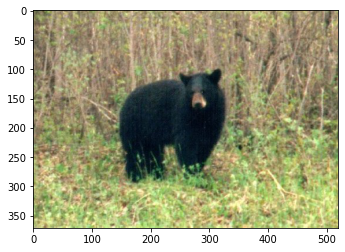

In [32]:
# Test trained_model on a test image
#! wget https://upload.wikimedia.org/wikipedia/commons/5/50/Male_gorilla_in_SF_zoo.jpg  -O gorilla.jpg
predict(trained_model, 'caltec_dataset/test/009_0098.jpg')

Predcition 1 : gorilla , Score:  0.99614316
Predcition 2 : bear , Score:  0.0023651943
Predcition 3 : other , Score:  0.0014916157


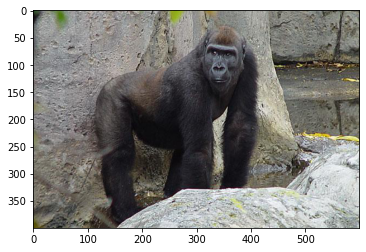

In [33]:
predict(trained_model, 'caltec_dataset/test/090_0107.jpg')

Predcition 1 : other , Score:  0.99304515
Predcition 2 : bear , Score:  0.0053570415
Predcition 3 : gorilla , Score:  0.0015977994


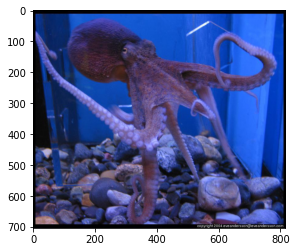

In [34]:
predict(trained_model, 'caltec_dataset/test/150_0044.jpg')